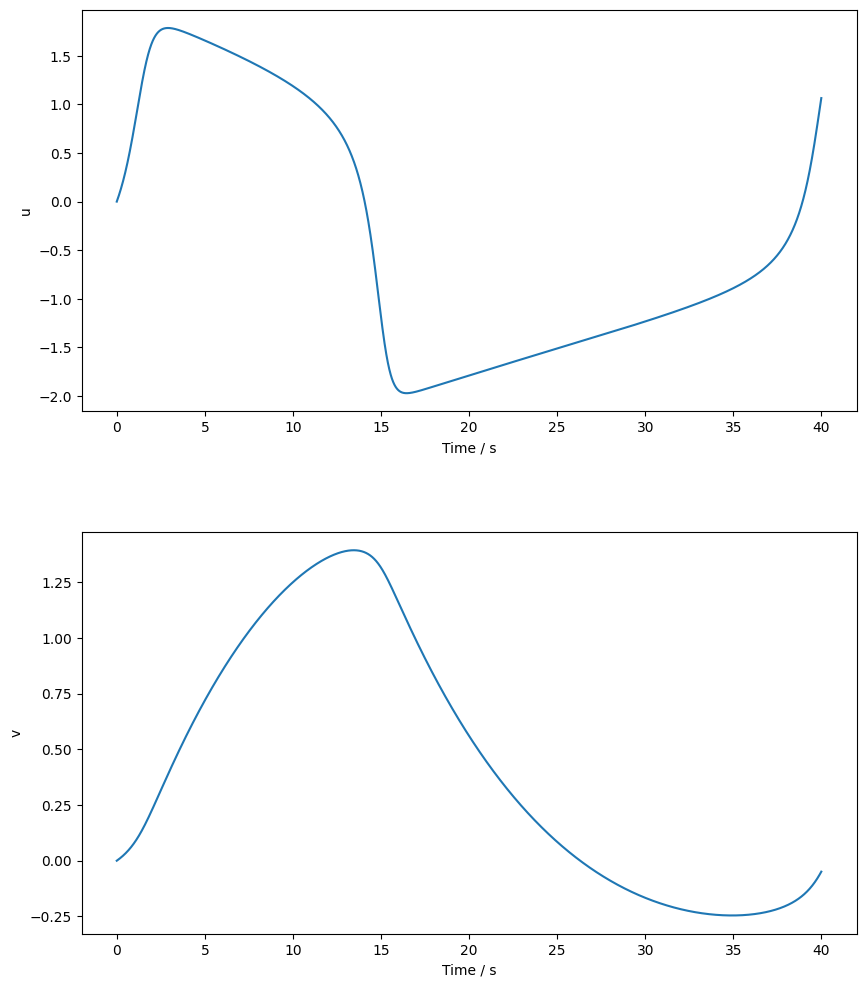

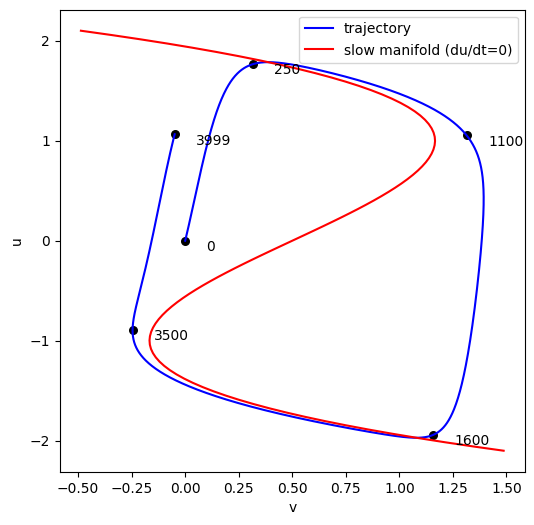

In [15]:
# %matplotlib inline
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


# 定义 FHN 系统的微分方程
def fhn(y, t):
    
    a, b, I, epsilon = 0.7, 0.8, 0.5, 0.08

    u, v = y
    dudt = u - u**3/3 - v + I
    dvdt = epsilon * (u + a - b*v)

    return [dudt, dvdt]

# 定义初值
u0, w0 = 0., 0.
y0 = [u0, w0]

# 定义时间间隔
t0 = 0
tf = 40
dt = 0.01
t = np.arange(t0, tf, dt)

# 运行微分方程求解器，获得模拟结果
sol = odeint(fhn, y0=y0, t=t)

# 绘制膜电位和恢复变量随时间演化的图形
plt.figure(figsize=(10,12))
for i in range(2):
    ax = plt.subplot(2,1,i+1)
    ax.plot(t, sol[:, i])
    ax.set_xlabel('Time / s')
    ax.set_ylabel(['u', 'v'][i])
plt.subplots_adjust(hspace=0.3)
plt.savefig('fhn.jpg', dpi=300)

# 绘制相空间轨迹和慢流型
u1 = np.linspace(-2.1,2.1,100)
v1 = u1-u1**3/3+0.5
point = [int(i/dt) for i in [0, 2.5, 11, 16, 35, tf-dt]] # 拐点
plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.scatter(sol[point, 1], sol[point, 0], s=30, c='black')
for i in range(len(point)):
    plt.annotate(str(point[i]), xy = (sol[point[i], 1], sol[point[i], 0]), xytext = (sol[point[i], 1]+0.1, sol[point[i], 0]-0.1))
ax.plot(sol[:, 1], sol[:, 0], c='b', label='trajectory')
ax.plot(v1, u1, c='r', label='slow manifold (du/dt=0)')
ax.set_xlabel('v')
ax.set_ylabel('u')
ax.legend()
plt.savefig('phase.jpg', dpi=300)

In [11]:
# 测试ID
import torch
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=64):
        super(Net, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(embedding_dim, embedding_dim),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(embedding_dim, embedding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(embedding_dim, embedding_dim),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(embedding_dim, output_dim)
        )

    def forward(self, x):

        embedding = self.encoder(x)
        out = self.decoder(embedding)

        return embedding, out

In [12]:
# Data set
point

[0, 250, 1100, 1600, 3500, 3999]

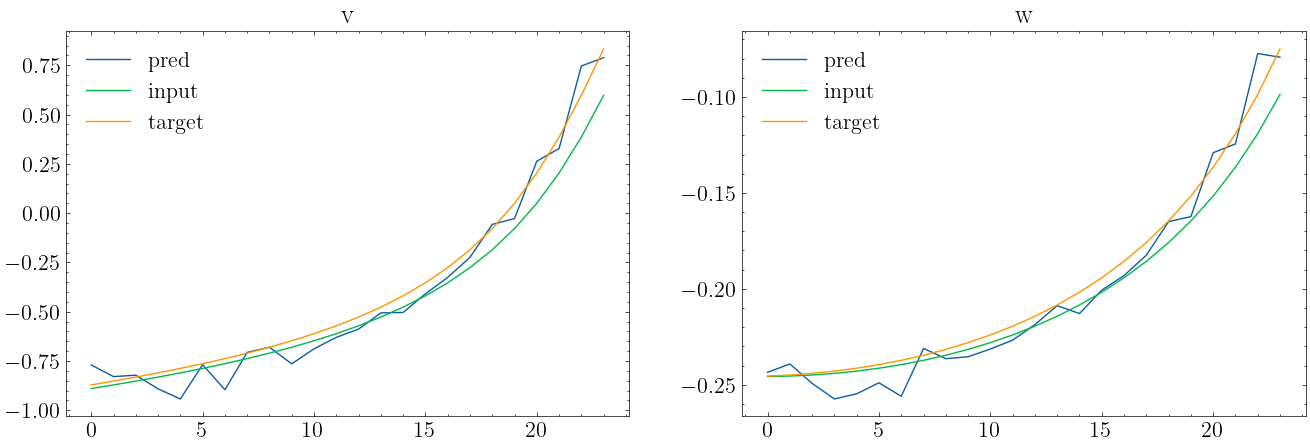

 [3500:3999] [10000/10000] loss=0.00217 MLE=1.22

In [13]:
from util.intrinsic_dimension import eval_id_embedding

for i in range(len(point)-1):

    print(f'\n{point[i]} : {point[i+1]}')
    data = torch.as_tensor(np.concatenate((sol[point[i]:point[i+1],:1], sol[point[i]:point[i+1],1:2]), axis=-1), dtype=torch.float32)
    
    lag = 0.2
    subsample = int(lag/dt)
    input = data[::subsample][:-1]
    target = data[::subsample][1:]

    net = Net(2,2)
    optim = torch.optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)
    loss_fn = nn.MSELoss()

    max_epoch = 10000
    for epoch in range(max_epoch):
        embedding, out = net(input)
        loss = loss_fn(out, target)
        optim.zero_grad()
        loss.backward()
        optim.step()

        if epoch % 1000 == 0:
            # ID
            embedding = embedding.detach().numpy()
            MLE_id = eval_id_embedding('', 'MLE', is_print=False, max_point=1000, embedding=embedding)

            # plot
            plt.figure(figsize=(16, 5))
            ax = plt.subplot(1,2,1)
            ax.plot(out[:,0].detach().numpy(), label='pred')
            ax.plot(input[:,0].detach().numpy(), label='input')
            ax.plot(target[:,0].detach().numpy(), label='target')
            ax.set_title('v')
            ax.legend()
            ax = plt.subplot(1,2,2)
            ax.plot(out[:,1].detach().numpy(), label='pred')
            ax.plot(input[:,1].detach().numpy(), label='input')
            ax.plot(target[:,1].detach().numpy(), label='target')
            ax.set_title('w')
            ax.legend()
            display.clear_output(wait=True)
            plt.pause(0.1) 
            plt.close()
        
        print(f'\r [{point[i]}:{point[i+1]}] [{epoch+1}/{max_epoch}] loss={loss.item():.5f} MLE={MLE_id:.2f}', end='')